In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Query data from the measurement table
results = session.query(Measurement.date, Measurement.prcp).all()
session.close()
df = pd.DataFrame(results, columns=['date', 'prcp'])
print(df.head())


         date  prcp
0  2010-01-01  0.08
1  2010-01-02  0.00
2  2010-01-03  0.00
3  2010-01-04  0.00
4  2010-01-06   NaN


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
#session.close()
latest_date

'2017-08-23'

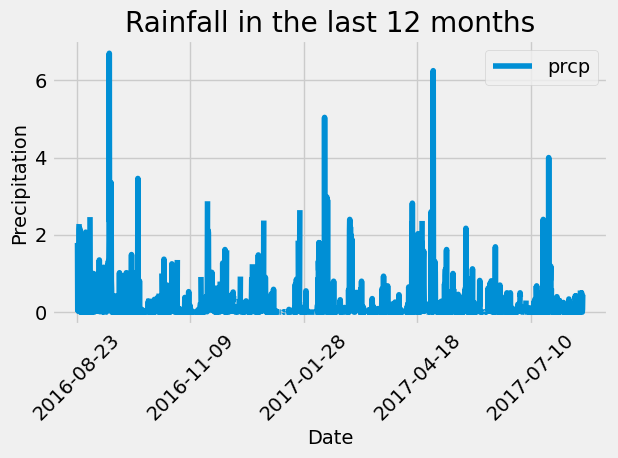

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date

# Calculate the date one year from the last date in data set.
one_year_ago_date = (dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])
df = df.sort_values('date')

# Sort the dataframe by date
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Rainfall in the last 12 months")
plt.tight_layout()

plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['prcp'].describe()
precipitation_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:

# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()
for station, count in active_stations:
    print(f"Estation: {station}, Rows: {count}")

Estation: USC00519281, Rows: 2772
Estation: USC00519397, Rows: 2724
Estation: USC00513117, Rows: 2709
Estation: USC00519523, Rows: 2669
Estation: USC00516128, Rows: 2612
Estation: USC00514830, Rows: 2202
Estation: USC00511918, Rows: 1979
Estation: USC00517948, Rows: 1372
Estation: USC00518838, Rows: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station (the first in the list)
most_active_station = active_stations[0][0]
# Design the query to calculate the lowest, highest, and average temperature for the most active season
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()
print(f"Most Active Station: {most_active_station}")
print(f"Lower Temperature: {temperature_stats[0][0]} °F")
print(f"Highest temperature: {temperature_stats[0][1]} °F")
print(f"Average Temperature: {temperature_stats[0][2]} °F")

Most Active Station: USC00519281
Lower Temperature: 54.0 °F
Highest temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


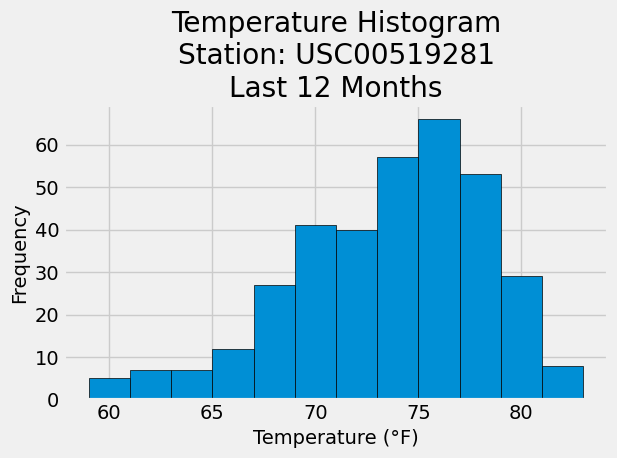

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Design the query to get the temperature data for the most active season in the last 12 months
temperature_data = session.query(Measurement.tobs).\
                   filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago_date).all()

# Convert the results to a flat list
temperature_list = [temp[0] for temp in temperature_data]

# Create a histogram
plt.hist(temperature_list, bins=12, edgecolor='black')
         
# Set tags and title
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Histogram\nStation: {most_active_station}\nLast 12 Months")
         
# show the histogram
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()